# Tombo: Extracting and Plotting Stats from yeast rRNA

## Sample Comparison statistics

### Compute per position KS-tests

$F_{n}(x)={1 \over n}\sum _{i=1}^{n}I_{[-\infty ,x]}(X_{i})$  
$D_{n}=\sup _{x}|F_{n}(x)-F(x)|$

* Code used to generate KS tests for each position
    * note: return_stat = True
    
```
def compute_ks_tests(samp_base_levels, ctrl_base_levels, return_stat):
    def compute_pos_ks_test(pos_samp_levels, pos_ctrl_levels):
        """Compute effect size statistic or p-value of two-sample
        Kolmogorov-Smirnov test

        Using definition from
        https://github.com/scipy/scipy/blob/v0.14.0/scipy/stats/stats.py#L3886
        """
        samp_n, ctrl_n = pos_samp_levels.shape[0], pos_ctrl_levels.shape[0]
        pos_all_levels = np.concatenate([pos_samp_levels, pos_ctrl_levels])
        samp_cdf = np.searchsorted(
            pos_samp_levels, pos_all_levels, side='right') / samp_n
        ctrl_cdf = np.searchsorted(
            pos_ctrl_levels, pos_all_levels, side='right') / ctrl_n
        d = np.max(np.absolute(samp_cdf - ctrl_cdf))
        if return_stat:
            # subtract 1 so most significant are smallest values
            return 1 - d
        en = np.sqrt(samp_n * ctrl_n / float(samp_n + ctrl_n))
        return stats.distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)


    samp_valid_indices = np.logical_not(np.isnan(samp_base_levels))
    ctrl_valid_indices = np.logical_not(np.isnan(ctrl_base_levels))
    return np.array([compute_pos_ks_test(
        np.sort(pos_samp_levels[samp_valid_indices[i]]),
        np.sort(pos_ctrl_levels[ctrl_valid_indices[i]]))
                     for i, (pos_samp_levels, pos_ctrl_levels) in enumerate(zip(
                             samp_base_levels, ctrl_base_levels))])
 ```
### Compute Window Mean

* lag = $l$  
$WindowMean_j = \frac{\sum _{i=j-l}^{j+l}D_i}{l}$


* Code used to calculate window mean 
    
 ```
 def calc_window_means(stats, lag):
    """Compute mean over a moving window across a set of statistics
    """
    assert lag > 0, 'Invalid window provided.'
    width = (lag * 2) + 1
    if stats.shape[-1] < width:
        raise th.TomboError(
            "Statistics vector too short for window mean compuation.")
    m_stats = np.empty(stats.shape)
    m_stats[:] = np.NAN
    m_stats[...,lag:-lag] = np.mean(np.lib.stride_tricks.as_strided(
        stats, shape=stats.shape[:-1] + (stats.shape[-1] - width + 1, width),
        strides=stats.strides + (stats.strides[-1],)), -1)

    return m_stats
```

In [2]:
# Tombo library
from tombo import tombo_helper, tombo_stats, resquiggle
# matplotlib library
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
# py3helpers
from py3helpers.classification import ClassificationMetrics
from py3helpers.utils import merge_lists
from py3helpers.seq_tools import ReferenceHandler

# Other common libraries
import pandas as pd
from sklearn.utils import assert_all_finite
from scipy import signal
from sklearn.linear_model import LinearRegression
from sklearn.metrics import auc

import numpy as np
# built in library
import os


In [3]:
HOME = "/Users/andrewbailey/CLionProjects/rrna_analysis" 
rh = ReferenceHandler("/Users/andrewbailey/CLionProjects/rrna_analysis/reference/yeast_25S_18S.fa")
figures = os.path.join(HOME, "figures/sample_compare")


In [4]:
CBF5_GAL_vs_CBF5_GLU = os.path.join(HOME, "tombo/CBF5_GAL_vs_GLU.level_compare_sample.tombo.stats")
CBF5_GAL_vs_NOP58_GAL = os.path.join(HOME, "tombo/CBF5_GAL_vs_NOP58_GAL.level_compare_sample.tombo.stats")
Nop58_GAL_vs_Nop58_GLU = os.path.join(HOME, "tombo/Nop58_GAL_vs_GLU.level_compare_sample.tombo.stats")
IVT_vs_CBF5_GAL_and_Nop58_GAL = os.path.join(HOME, "tombo/IVT_vs_CBF5_GAL_and_Nop58_GAL.level_compare_sample.tombo.stats")
IVT_vs_Nop58_GAL = os.path.join(HOME, "tombo/IVT_vs_Nop58_GAL.level_compare_sample.tombo.stats")
IVT_vs_Nop58_GLU = os.path.join(HOME, "tombo/IVT_vs_Nop58_GLU.level_compare_sample.tombo.stats")
IVT_vs_CBF5_GLU = os.path.join(HOME, "tombo/IVT_vs_CBF5_GLU.level_compare_sample.tombo.stats")

output_mods = os.path.join(HOME, "reference/mod_files/yeast_18S_25S_variants.positions")
nanocompore = "/Users/andrewbailey/CLionProjects/rrna_analysis/nanocompore/out_nanocompore_results.tsv"


In [5]:
mods_data = {"RDN18-1": [], "RDN25-1": []}
with open(output_mods, 'r') as fh:
    for line in fh:
        split_line = line.split()
        contig = split_line[0]
        pos = int(split_line[1])
        strand = split_line[2]
        find = split_line[3]
        mods = split_line[4]
        mods_data[contig].append([pos+1, strand, find, mods])


In [6]:
%matplotlib inline
# stats_files = [CBF5_GAL_vs_CBF5_GLU, CBF5_GAL_vs_NOP58_GAL, Nop58_GAL_vs_Nop58_GLU, IVT_vs_CBF5_GAL_and_Nop58_GAL]
# labels = ["CBF5_GAL vs CBF5_GLU", "CBF5_GAL vs NOP58_GAL", "Nop58_GAL vs Nop58_GLU", "IVT vs CBF5_GAL_and_Nop58_GAL"]

def generate_tombo_plots(stats_files, labels, rrna_ref_name, mods_data=mods_data, save_fig_path=None, color=True):
    title = f"Per-position Windowed Mean D-statistics: {rrna_ref_name}"

    fig = plt.figure(figsize=(20, 6))
    panel1 = plt.axes([0.1, 0.1, .8, .8])
    panel1.set_xlabel(f"{rrna_ref_name} Reference Positions")
    panel1.set_ylabel("D-statistic")
    panel1.set_title(label=title)

    panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)


    for i in range(len(stats_files)):
        assert os.path.exists(stats_files[i])
        ts = tombo_stats.TomboStats(stats_files[i])
        for contig in ts:
            if contig[0] == rrna_ref_name and contig[1] == "+":
                all_data = contig[4]
                panel1.plot([x[1] for x in all_data], [1-x[0] for x in all_data], label=labels[i])
        
    for i, mod in enumerate(mods_data[rrna_ref_name]):
        pos = mod[0] 
        strand = mod[1]
        find = mod[2]
        mods = mod[3]
        if i == 0:
            panel1.plot(pos, 1-all_data[all_data["pos"] == pos]["stat"], color='r', linewidth=0, marker='o', ms=5, label=f"Annotated Modified Positions on {rrna_ref_name}")
        else:
            panel1.plot(pos, 1-all_data[all_data["pos"] == pos]["stat"], color='r', marker='o')


    panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
    panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))
    panel1.set_ylim(0, 1)
    panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

    panel1.legend()

    # option to save figure or just show it
    if save_fig_path is not None:
        plt.savefig(save_fig_path, transparent=False)
    else:
        plt.show

<IPython.core.display.Javascript object>


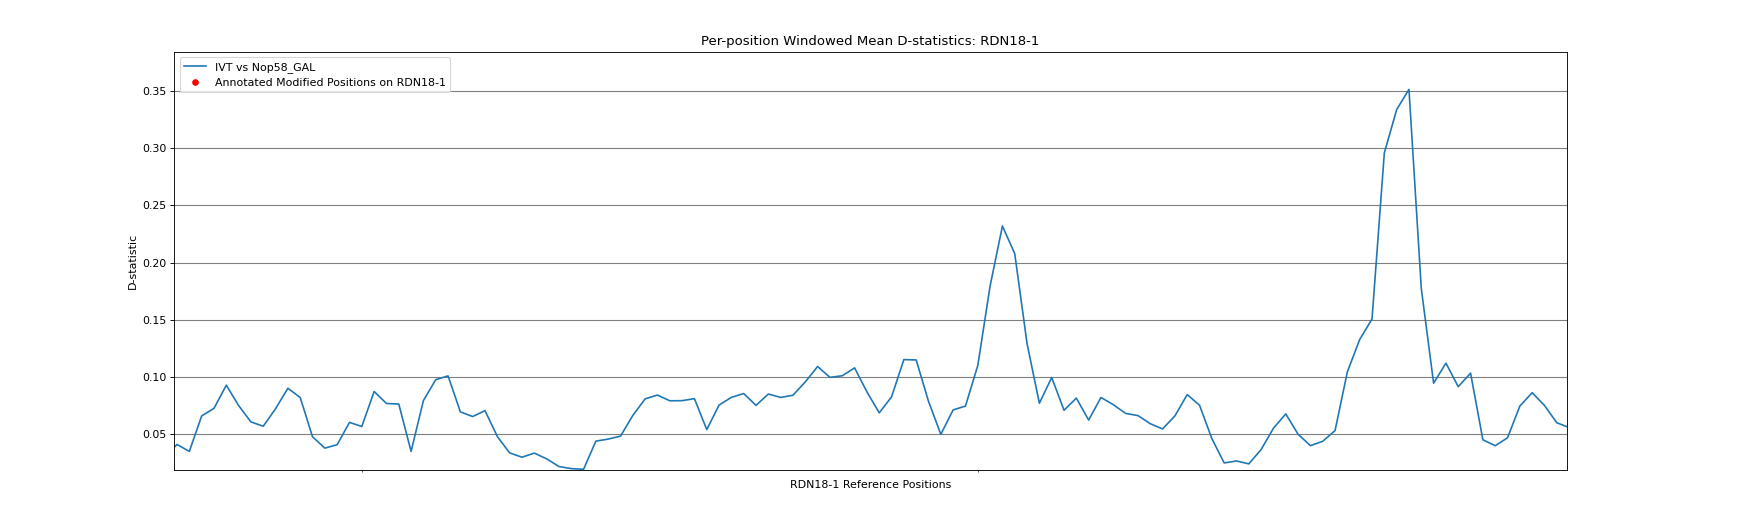

In [109]:
%matplotlib notebook
rrna_ref_name = "RDN18-1"
stats_files = [IVT_vs_Nop58_GAL]
labels = ["IVT vs Nop58_GAL"]
save_fig_path=os.path.join(figures, f"tombo_{rrna_ref_name}_plot.svg")
save_fig_path=None
generate_tombo_plots(stats_files, labels, rrna_ref_name, save_fig_path=save_fig_path)
# save_fig_path=os.path.join(figures, f"tombo_{rrna_ref_name}_plot.png")
# generate_tombo_plots(stats_files, labels, rrna_ref_name, save_fig_path=save_fig_path)


<IPython.core.display.Javascript object>


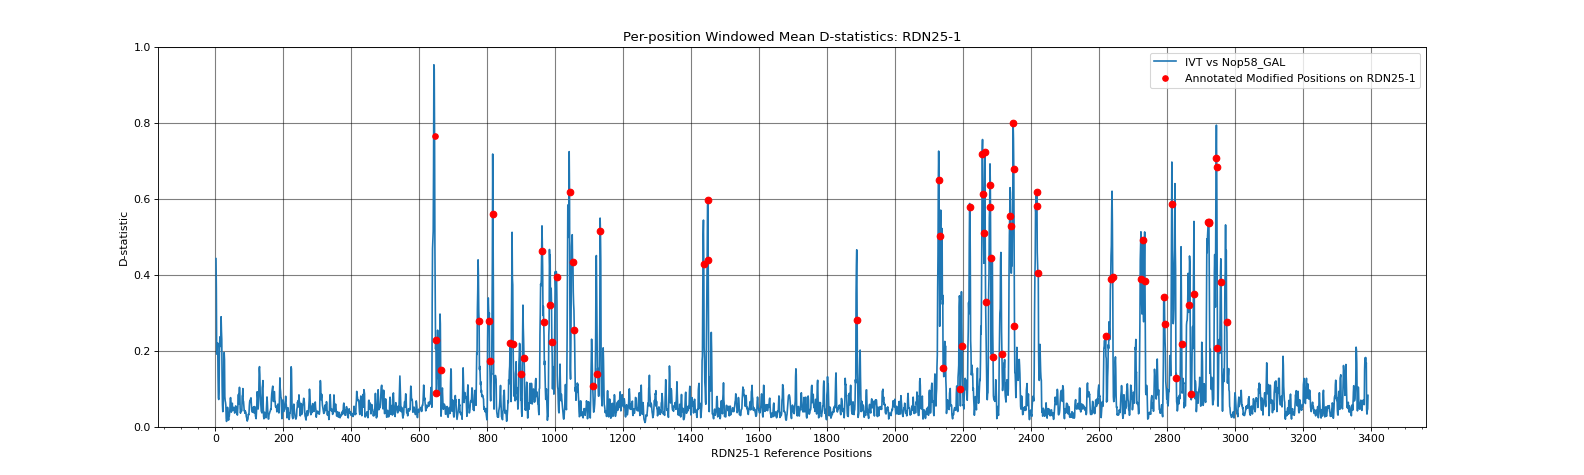

In [7]:
%matplotlib notebook

rrna_ref_name = "RDN25-1"
save_fig_path=os.path.join(figures, f"tombo_{rrna_ref_name}_plot.svg")
save_fig_path=None
generate_tombo_plots(stats_files, labels, rrna_ref_name, save_fig_path=save_fig_path)
# save_fig_path=os.path.join(figures, f"tombo_{rrna_ref_name}_plot.png")
# generate_tombo_plots(stats_files, labels, rrna_ref_name, save_fig_path=save_fig_path)


<IPython.core.display.Javascript object>


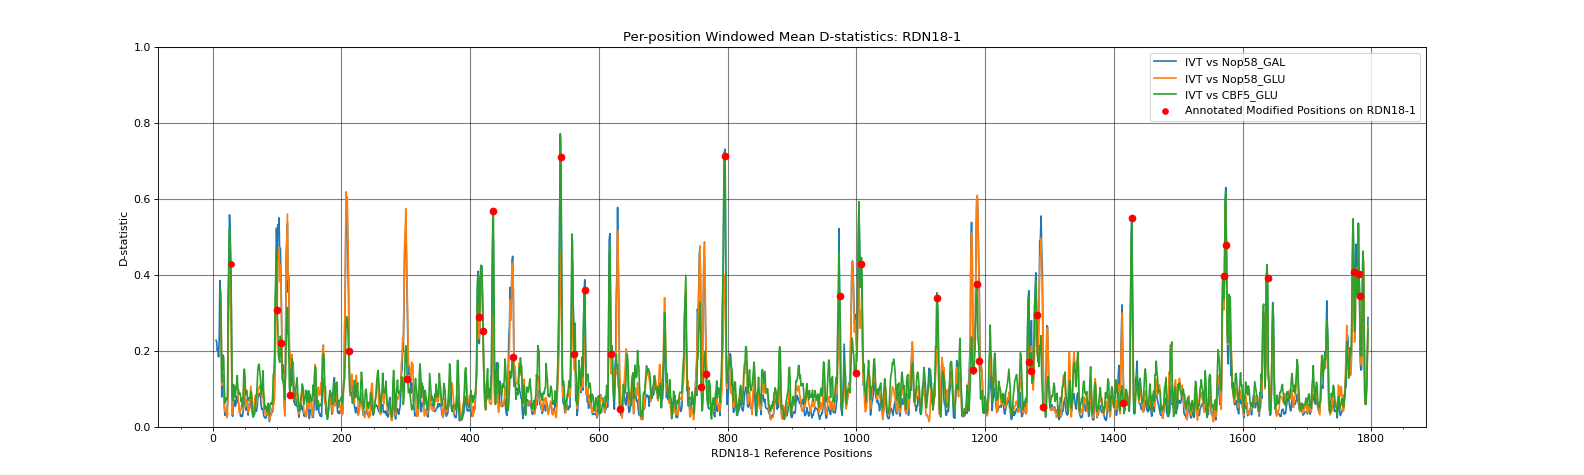

In [10]:
%matplotlib notebook

rrna_ref_name = "RDN18-1"
stats_files = [IVT_vs_Nop58_GAL, IVT_vs_Nop58_GLU, IVT_vs_CBF5_GLU]
labels = ["IVT vs Nop58_GAL", "IVT vs Nop58_GLU", "IVT vs CBF5_GLU"]
save_fig_path=None
generate_tombo_plots(stats_files, labels, rrna_ref_name, save_fig_path=save_fig_path)


In [57]:

def plot_tombo_roc(stats_file, rrna_ref_name, mods_data=mods_data, save_fig_paths=None, thresholds_at=None):
    tombo_data = {}
    label_data = {}
    probs = []

    column_names = ["unmod", "mod"]
    ts = tombo_stats.TomboStats(stats_file)
    for contig in ts:
        if contig[0] == rrna_ref_name and contig[1] == "+":
            all_data = contig[4]
            min_pos = all_data[0][1]
            max_pos = all_data[-1][1]
            for x in all_data:
                tombo_data[x[1]] = [x[0], 1-x[0]]
                label_data[x[1]] = [1, 0]
                probs.append(1-x[0])
    title = f"Tombo Distribution of 1 - D-statistic: {rrna_ref_name}"

    fig = plt.figure(figsize=(10, 8))
    panel1 = plt.axes([0.1, 0.1, .8, .8])
    panel1.set_xlabel("1 - D-statistic")
    panel1.set_ylabel("Counts")
    panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
    panel1.set_title(label=title)
    panel1.hist(probs, label="IVT vs Native (NOP58_GAL)", bins=30)
    # panel1.axvline(x=np.mean(probs)-(2*(np.std(probs))), linewidth=5, color='g')
    for i, mod in enumerate(mods_data[rrna_ref_name]):
        pos = mod[0] 
        strand = mod[1]
        find = mod[2]
        mods = mod[3]
        label_data[pos] = [0, 1]
        if tombo_data[pos][0] > 0.75:
            print(pos, tombo_data[pos][0])
        if i == 0:
            panel1.axvline(x=tombo_data[pos][0], linewidth=1, color='r', label=f"Annotated Modified Positions on {rrna_ref_name}")
        else:
            panel1.axvline(x=tombo_data[pos][0], linewidth=1, color='r')
    panel1.legend()

    # option to save figure or just show it
    if save_fig_paths is not None:
        plt.savefig(save_fig_paths[0])


    final_prob_data = []
    final_label_data = []                       
    for i in range(min_pos, max_pos+1):
        final_prob_data.append(tombo_data[i])
        final_label_data.append(label_data[i])     

    cm = ClassificationMetrics(pd.DataFrame(final_label_data, columns=column_names), 
                               pd.DataFrame(final_prob_data, columns=column_names), 
                               label_ids=list(range(min_pos, max_pos+1)))
    cm.plot_roc("mod", title=f"Tombo Reciever Operation Curve: {rrna_ref_name}", save_fig_path=save_fig_paths[1], thresholds_at=thresholds_at)

120 0.8232959986256224
414 0.780962135679435
562 0.8064927606247746
619 0.8074276921166583
632 0.9010297463777132
759 0.8868770678230722
766 0.7843839156376685
999 0.7516275426985976
1181 0.7508105410972062
1269 0.811188068238445
1271 0.7783460326842876
1290 0.7846804189709379
1415 0.8813696186390659
120 0.8232959986256224
414 0.780962135679435
562 0.8064927606247746
619 0.8074276921166583
632 0.9010297463777132
759 0.8868770678230722
766 0.7843839156376685
999 0.7516275426985976
1181 0.7508105410972062
1269 0.811188068238445
1271 0.7783460326842876
1290 0.7846804189709379
1415 0.8813696186390659


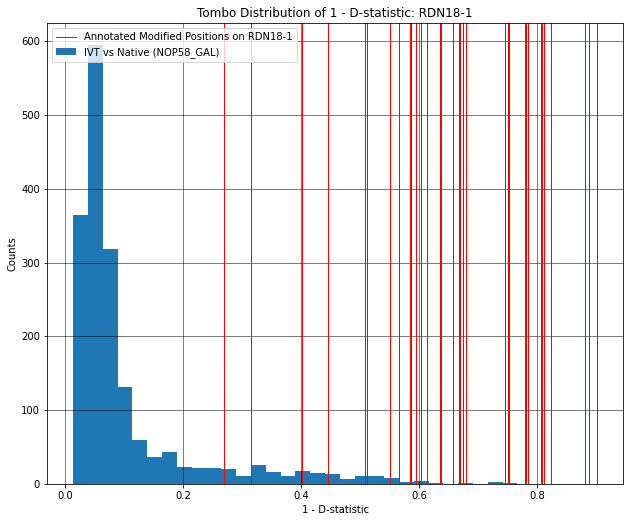

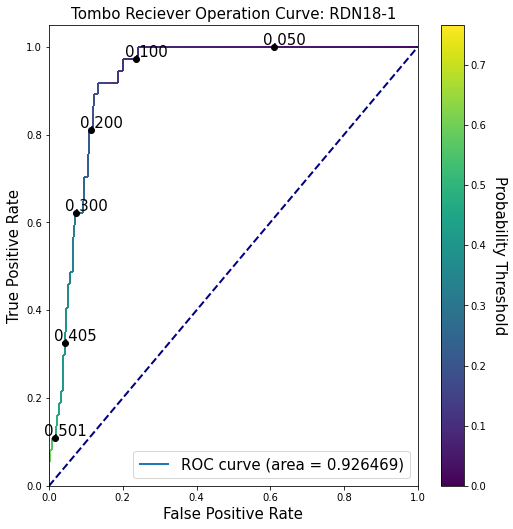

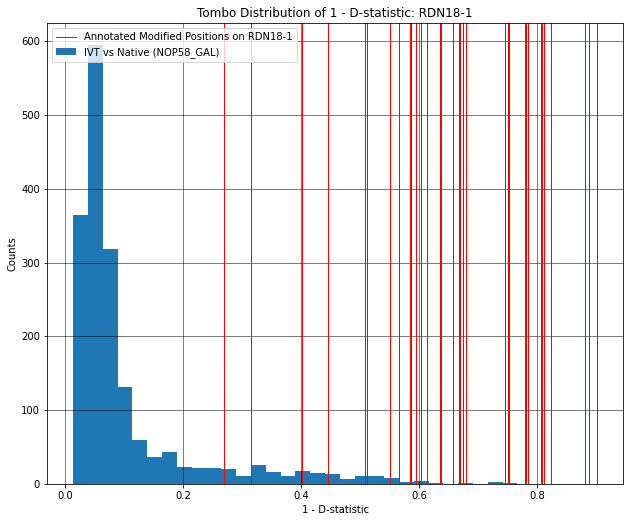

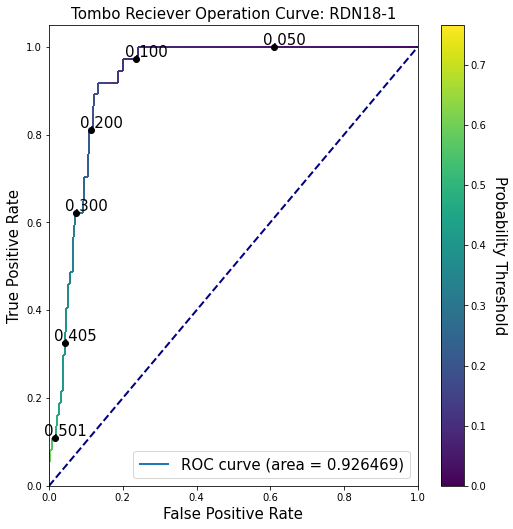

In [63]:
%matplotlib inline

rrna_ref_name = "RDN18-1"
stats_file = IVT_vs_Nop58_GAL
thresholds_at = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
plot_tombo_roc(stats_file, rrna_ref_name, mods_data=mods_data, save_fig_paths=[os.path.join(figures, f"tombo_{rrna_ref_name}_dist.svg"), os.path.join(figures, f"tombo_{rrna_ref_name}_roc.svg")], thresholds_at=thresholds_at)
plot_tombo_roc(stats_file, rrna_ref_name, mods_data=mods_data, save_fig_paths=[os.path.join(figures, f"tombo_{rrna_ref_name}_dist.png"), os.path.join(figures, f"tombo_{rrna_ref_name}_roc.png")], thresholds_at=thresholds_at)


649 0.7708274465218382
650 0.9115862520322731
663 0.8517048968594682
807 0.8273749134782092
867 0.7792096820993999
876 0.782820839465821
898 0.8613258395172642
908 0.8184971611882198
990 0.7758836482839812
1110 0.8941133885863982
1124 0.8620568760168267
2142 0.8449026092521376
2191 0.9019576443167711
2197 0.7887626015109673
2288 0.8163518094392727
2314 0.8097211965398078
2619 0.7616586437117189
2826 0.8726257576205523
2843 0.7818525372909647
2870 0.9143700157717042
2948 0.7924893314516805
649 0.7708274465218382
650 0.9115862520322731
663 0.8517048968594682
807 0.8273749134782092
867 0.7792096820993999
876 0.782820839465821
898 0.8613258395172642
908 0.8184971611882198
990 0.7758836482839812
1110 0.8941133885863982
1124 0.8620568760168267
2142 0.8449026092521376
2191 0.9019576443167711
2197 0.7887626015109673
2288 0.8163518094392727
2314 0.8097211965398078
2619 0.7616586437117189
2826 0.8726257576205523
2843 0.7818525372909647
2870 0.9143700157717042
2948 0.7924893314516805


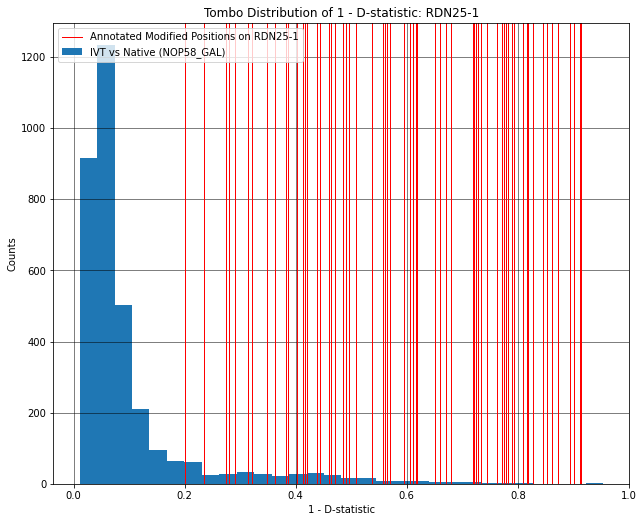

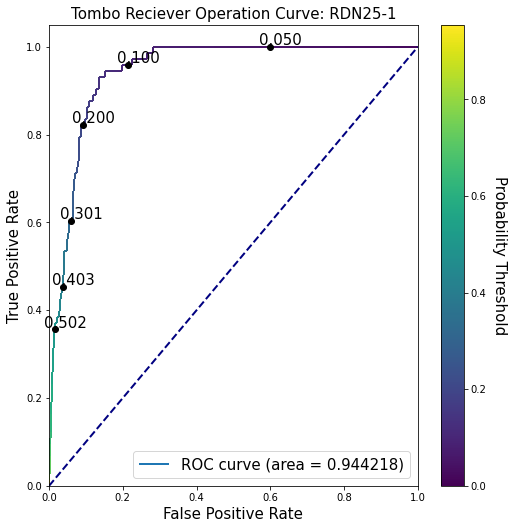

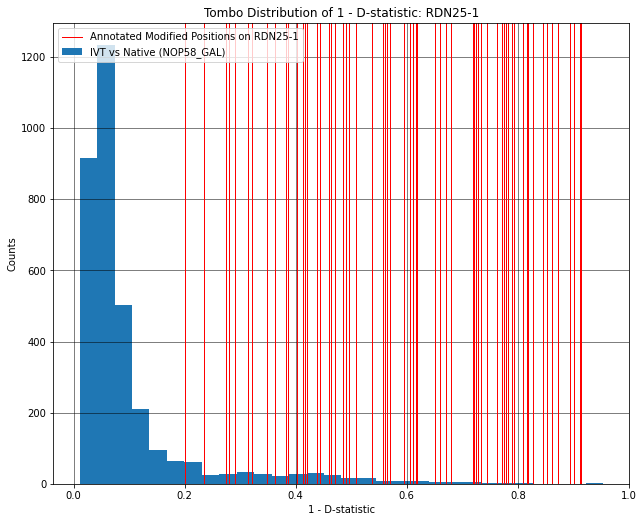

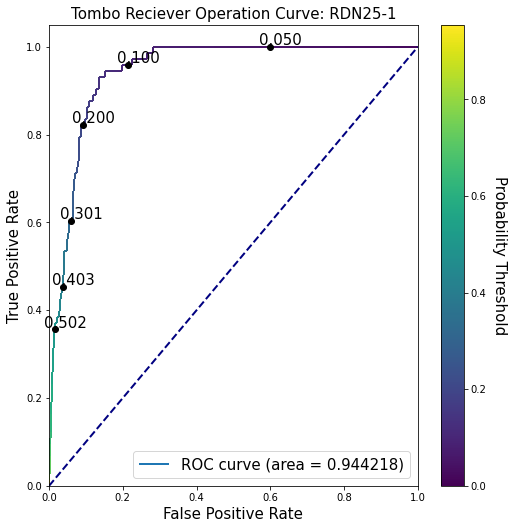

In [64]:
%matplotlib inline

rrna_ref_name = "RDN25-1"
stats_file = IVT_vs_Nop58_GAL
thresholds_at = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
plot_tombo_roc(stats_file, rrna_ref_name, mods_data=mods_data, save_fig_paths=[os.path.join(figures, f"tombo_{rrna_ref_name}_dist.svg"), os.path.join(figures, f"tombo_{rrna_ref_name}_roc.svg")], thresholds_at=thresholds_at)
plot_tombo_roc(stats_file, rrna_ref_name, mods_data=mods_data, save_fig_paths=[os.path.join(figures, f"tombo_{rrna_ref_name}_dist.png"), os.path.join(figures, f"tombo_{rrna_ref_name}_roc.png")], thresholds_at=thresholds_at)


# NANOCOMPORE

In [65]:
nanocompore = "/Users/andrewbailey/CLionProjects/rrna_analysis/nanocompore/out_nanocompore_results.tsv"


In [66]:
def generate_nanocompore_plots(stats_files, labels, rrna_ref_name, mods_data=mods_data, save_fig_path=None):
    title = f"Histogram of per-position log(GMM_logit_pvalue): {rrna_ref_name}"

    fig = plt.figure(figsize=(20, 6))
    panel1 = plt.axes([0.1, 0.1, .8, .8])
    panel1.set_xlabel(f"{rrna_ref_name} Reference Positions")
    panel1.set_ylabel("log(GMM_logit_pvalue)")
    panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)

    panel1.set_title(label=title)

    for i in range(len(stats_files)):
        assert os.path.exists(stats_files[i])
        nanocompore_data = pd.read_csv(nanocompore, sep="\t")
        contig_data = nanocompore_data[nanocompore_data["ref_id"]==rrna_ref_name]
        panel1.plot([x["pos"] for index, x in contig_data.iterrows()], [np.log(x["GMM_logit_pvalue"]) for index, x in contig_data.iterrows()], label=labels[i])

    for i, mod in enumerate(mods_data[rrna_ref_name]):
        pos = mod[0] 
        strand = mod[1]
        find = mod[2]
        mods = mod[3]
        if i == 0:
            panel1.plot(pos, np.log(contig_data[contig_data["pos"] == pos]["GMM_logit_pvalue"]), color='r', linewidth=0, marker='o', ms=5, label=f"Annotated Modified Positions on {rrna_ref_name}")
        else:
            panel1.plot(pos, np.log(contig_data[contig_data["pos"] == pos]["GMM_logit_pvalue"]), color='r', marker='o', ms=5)


    panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
    panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))

    panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

    panel1.legend()

    # option to save figure or just show it
    if save_fig_path is not None:
        plt.savefig(save_fig_path)


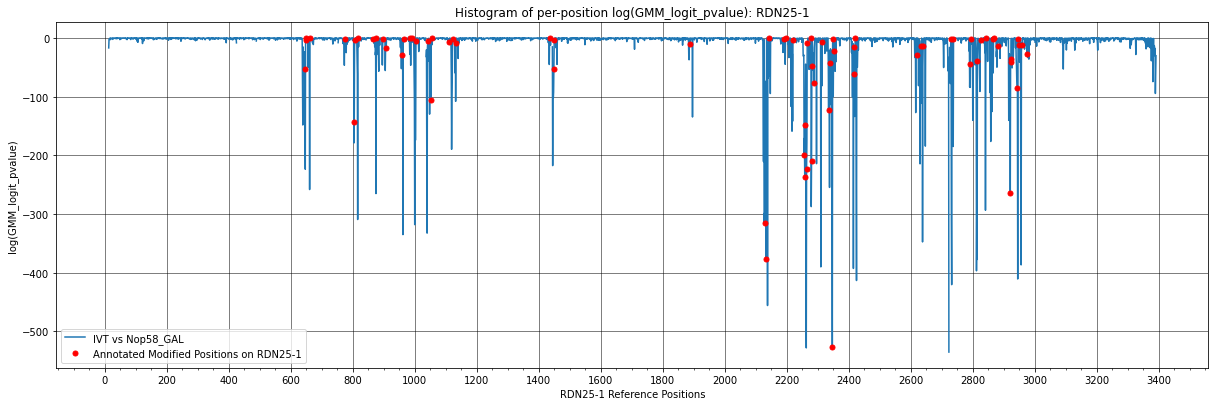

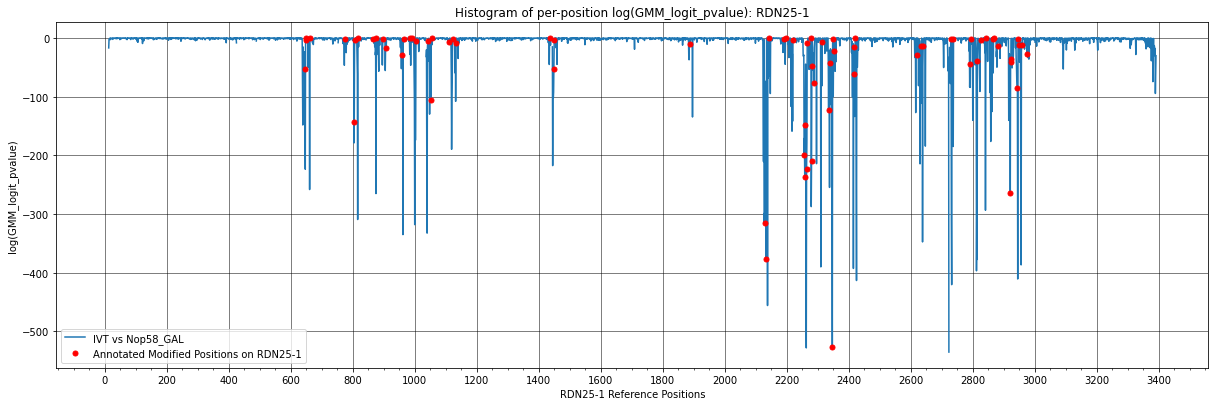

In [69]:
%matplotlib inline

stats_files = [nanocompore]
labels = ["IVT vs Nop58_GAL"]
rrna_ref_name = "RDN25-1"
generate_nanocompore_plots(stats_files, labels, rrna_ref_name, save_fig_path=os.path.join(figures, f"nanocompore_{rrna_ref_name}_plot.svg"))
generate_nanocompore_plots(stats_files, labels, rrna_ref_name, save_fig_path=os.path.join(figures, f"nanocompore_{rrna_ref_name}_plot.png"))


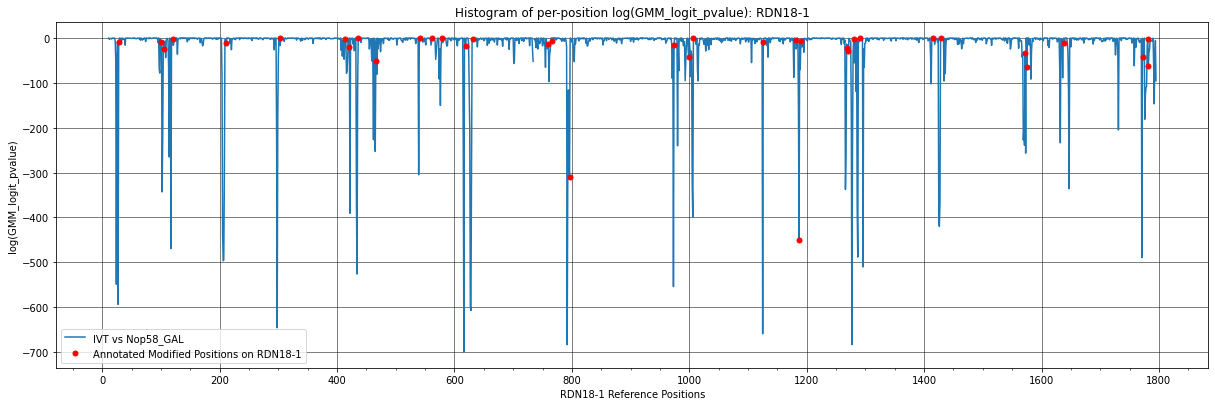

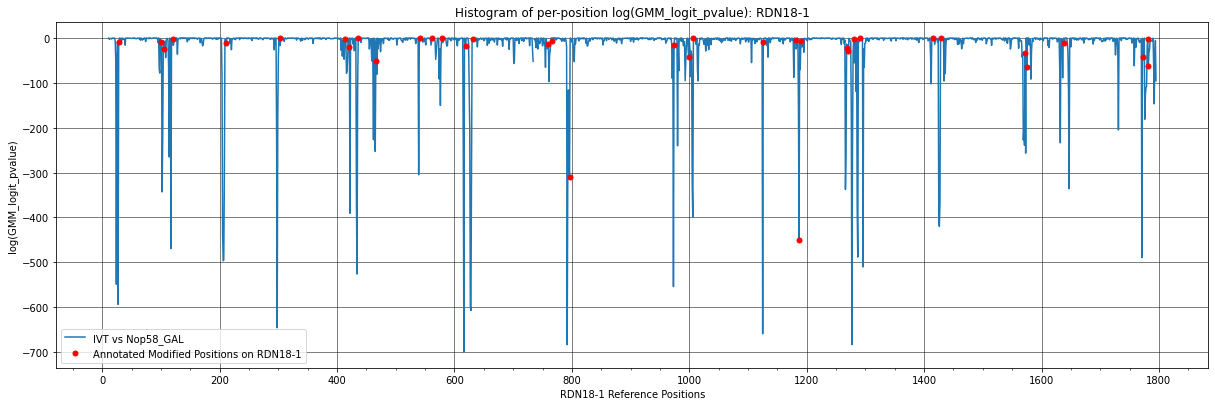

In [70]:
%matplotlib inline

rrna_ref_name = "RDN18-1"
generate_nanocompore_plots(stats_files, labels, rrna_ref_name, save_fig_path=os.path.join(figures, f"nanocompore_{rrna_ref_name}_plot.svg"))
generate_nanocompore_plots(stats_files, labels, rrna_ref_name, save_fig_path=os.path.join(figures, f"nanocompore_{rrna_ref_name}_plot.png"))


In [71]:
def plot_nanocompore_roc(stats_file, rrna_ref_name, mods_data=mods_data, save_fig_paths=None, thresholds_at=None):
    nc_data = {}
    label_data = {}
    probs = []

    nanocompore_data = pd.read_csv(nanocompore, sep="\t")
    contig_data = nanocompore_data[nanocompore_data["ref_id"]==rrna_ref_name]
    contig_data.dropna(1, "all", inplace=True)

    column_names = ["unmod", "mod"]
    min_pos = min(contig_data["pos"])
    max_pos = max(contig_data["pos"])


    for index, row in contig_data.iterrows():
        pvalue = row['GMM_logit_pvalue']
        if sum(row.isna()) > 0:
            pvalue = 1
        nc_data[row['pos']] = [pvalue, 1-pvalue]
        label_data[row['pos']] = [1, 0]
        probs.append(row['GMM_logit_pvalue'])

    save_fig_path = None

    title = "Distribution of log(GMM_logit_pvalue)"

    fig = plt.figure(figsize=(8, 8))
    panel1 = plt.axes([0.1, 0.1, .8, .8])
    panel1.set_xlabel("GMM_logit_pvalue")
    panel1.set_ylabel("Counts")
    panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
    panel1.set_title(label=title)
    panel1.hist(probs, label="IVT vs Native (NOP58_GAL)", bins=30)
    # panel1.axvline(x=np.mean(probs)-(2*(np.std(probs))), linewidth=5, color='g')
    for i, mod in enumerate(mods_data[rrna_ref_name]):
        pos = mod[0] 
        strand = mod[1]
        find = mod[2]
        mods = mod[3]
        label_data[pos] = [0, 1]
        if i == 0:
            panel1.axvline(x=nc_data[pos][0], linewidth=1, color='r', label=f"Annotated Modified Positions on {rrna_ref_name}")
        else:
            panel1.axvline(x=nc_data[pos][0], linewidth=1, color='r')
    panel1.legend()

    final_prob_data = []
    final_label_data = []                       
    for i in sorted(list(nc_data.keys())):
        final_prob_data.append(([0, 1] if nc_data[i][0] < 0.00000001 else nc_data[i]))
        final_label_data.append(label_data[i])     

    cm = ClassificationMetrics(pd.DataFrame(final_label_data, columns=column_names), 
                               pd.DataFrame(final_prob_data, columns=column_names), 
                               label_ids=sorted(nc_data.keys()))
    cm.plot_roc("mod", title=f"Nanocompore Reciever Operation Curve: {rrna_ref_name}", save_fig_path=save_fig_paths[1], thresholds_at=thresholds_at, 
                cbar_label="p-value threshold")

/Users/andrewbailey/anaconda3/envs/signalalign/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/andrewbailey/anaconda3/envs/signalalign/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


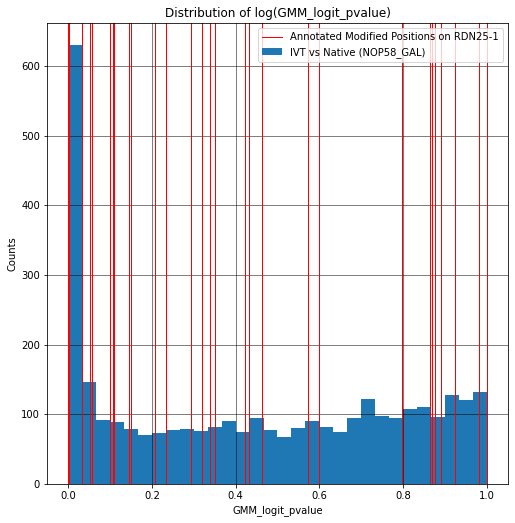

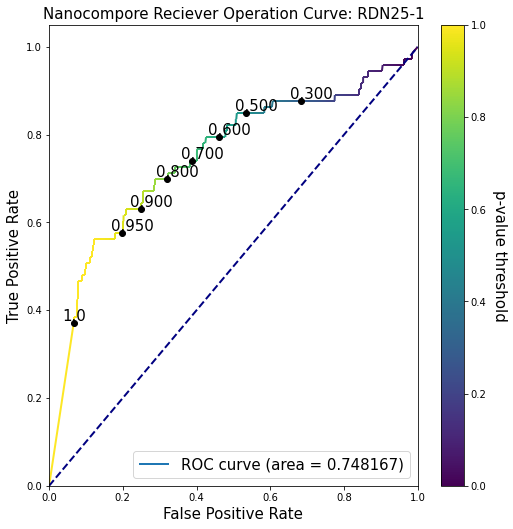

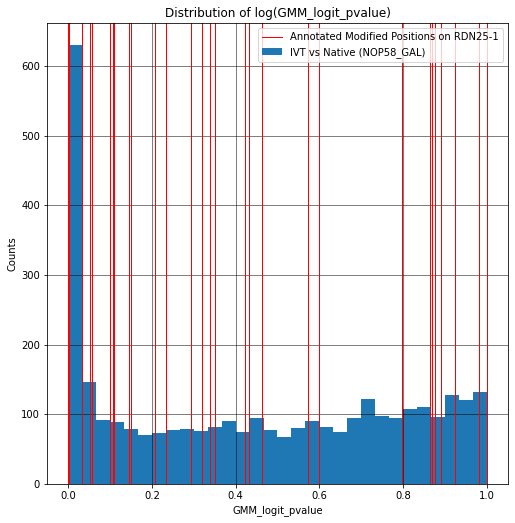

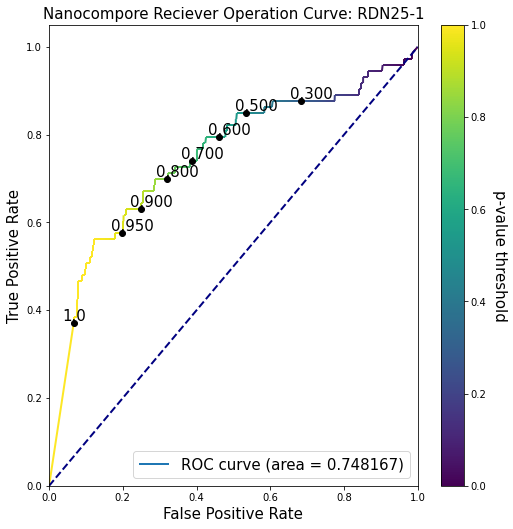

In [72]:
%matplotlib inline
stats_file = nanocompore
rrna_ref_name = "RDN25-1"
thresholds_at = [1, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.3]
plot_nanocompore_roc(stats_file, rrna_ref_name, save_fig_paths=[os.path.join(figures, f"nanocompore_{rrna_ref_name}_dist.svg"), os.path.join(figures, f"nanocompore_{rrna_ref_name}_roc.svg")], thresholds_at=thresholds_at)
plot_nanocompore_roc(stats_file, rrna_ref_name, save_fig_paths=[os.path.join(figures, f"nanocompore_{rrna_ref_name}_dist.svg"), os.path.join(figures, f"nanocompore_{rrna_ref_name}_roc.png")], thresholds_at=thresholds_at)


/Users/andrewbailey/anaconda3/envs/signalalign/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/andrewbailey/anaconda3/envs/signalalign/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


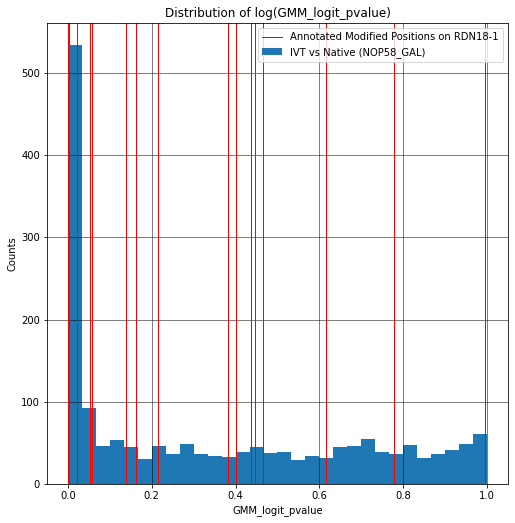

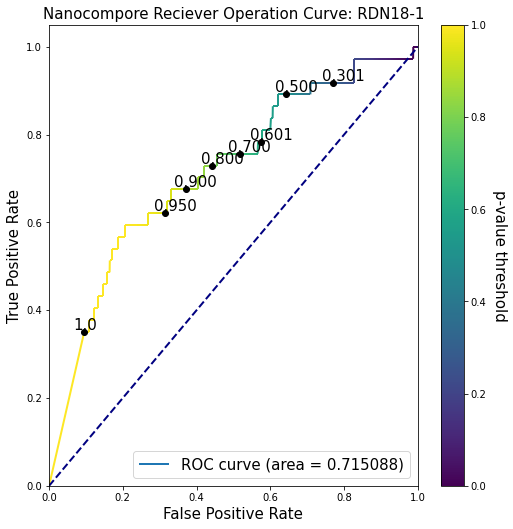

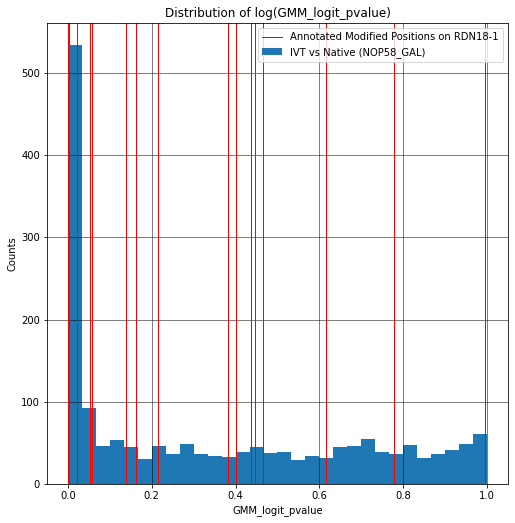

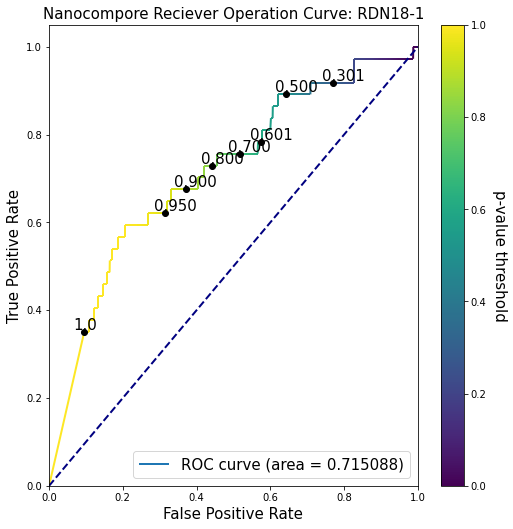

In [73]:
stats_file = nanocompore
rrna_ref_name = "RDN18-1"
thresholds_at = [1, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.3]
plot_nanocompore_roc(stats_file, rrna_ref_name, save_fig_paths=[os.path.join(figures, f"nanocompore_{rrna_ref_name}_dist.svg"), os.path.join(figures, f"nanocompore_{rrna_ref_name}_roc.svg")], thresholds_at=thresholds_at)
plot_nanocompore_roc(stats_file, rrna_ref_name, save_fig_paths=[os.path.join(figures, f"nanocompore_{rrna_ref_name}_dist.svg"), os.path.join(figures, f"nanocompore_{rrna_ref_name}_roc.png")], thresholds_at=thresholds_at)


### Generate more reasonable modification detection ROC

In [7]:
def get_data_from_tombo(stats_file, contig_name, strand="+"):
    assert os.path.exists(stats_file)
    ts = tombo_stats.TomboStats(stats_file)
    for contig in ts:
        if contig[0] == contig_name and contig[1] == strand:
            all_data = contig[4]
            raw_data = [1-x[0] for x in all_data][10:]
            ref_positions = [x[1] for x in all_data][10:]
            return raw_data, ref_positions

def is_position_modified(position, peaks, properties, min_ref, delta=5):
    for l, r in zip(properties["left_ips"]+min_ref, properties["right_ips"]+min_ref):
        if l <= position <= r:
            return True

        
def get_peaks_accuracy(peaks, properties, mods_data, contig_name, min_ref, max_ref, delta=5):
    score = 0
    fp = 0
    tp = 0
    tn = 0
    fn = 0
    mod_index = 0
    mods_per_peak = []
    mod_per_peak_widths = []
    n_mods = len(mods_data[contig_name])
    for l, r in zip(properties["left_ips"]+min_ref, properties["right_ips"]+min_ref):
        total_mods = 0
        all_mods_found = []
        keep_going = True
        while keep_going:
            pos = mods_data[contig_name][mod_index][0]
            if pos < l:
                fn += 1
                mod_index += 1
            elif r < pos:
                if total_mods == 0:
                    fp += 1
                keep_going = False
            else:
                tp += 1
                total_mods += 1
                mod_index += 1
                all_mods_found.append(pos)

            if mod_index == n_mods:
                mod_index -= 1
                keep_going = False

    #         print(l, r, pos, keep_going, tp, fp, tn, fn, score)
        score += get_score(total_mods)
        if total_mods > 1:
            delta = all_mods_found[-1] - all_mods_found[0]
        else:
            delta = 0
        mods_per_peak.append([total_mods, delta])
        mod_per_peak_widths.append([r-l])
    return tp, fp, tn, fn, score, mods_per_peak, mod_per_peak_widths

def plot_fit(reg, mods_per_peak, mod_per_peak_widths):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs = [x[0] for x in mods_per_peak]
    ys = [x[1] for x in mods_per_peak]
    ax.scatter(xs=xs, ys=ys, zs=mod_per_peak_widths)
    z = reg.predict(X)
    ax.plot(xs=[x[0] for x in z], ys=[x[1] for x in z], zs=merge_lists(X))
    plt.show()

def get_score_and_regression(raw_data, 
                             ref_positions,
                             mods_data, 
                             contig_name,
                             function,
                             height=None, 
                             distance=None, 
                             threshold=None, 
                             width=None, 
                             prominence=None, 
                             wlen=None, 
                             rel_height=None,
                             delta=5):
    if distance is not None and distance < 1.0:
        distance = None
    if threshold is not None and threshold < 0.0:
        threshold = None
    if wlen is not None and wlen < 2:
        wlen = None
    peaks, properties = signal.find_peaks(raw_data, 
                                          height=height, 
                                          distance=distance, 
                                          threshold=threshold, 
                                          width=width, 
                                          prominence=prominence, 
                                          wlen=wlen, 
                                          rel_height=rel_height)
    min_ref = min(ref_positions)
    max_ref = max(ref_positions)
    if len(peaks) == 0:
        return None, -np.inf, 0, 0, get_true_negatives(mods_data[contig_name], min_ref, max_ref, delta=delta), len(mods_data[contig_name]), None, None, peaks, properties
    tp, fp, tn, fn, score, mods_per_peak, mod_per_peak_widths = function(peaks, properties, mods_data, contig_name, min_ref, max_ref, delta=delta)
    X, y = np.array(mod_per_peak_widths), np.array(mods_per_peak)
    reg = LinearRegression().fit(X, y)
#     print(reg.coef_)
#     print(reg.intercept_)
    reg_score = reg.score(X, y)
#     print(tp, fp, tn, fn, score, reg_score, sum(reg.coef_)[0]) 
#     if score > 15:
#         reg_score += sum(reg.coef_)[0]
    total_score = score + 30*(reg_score) - fn
    return reg, total_score, tp, fp, tn, fn, mods_per_peak, mod_per_peak_widths, peaks, properties

def is_position_modified2(position, peaks, properties, min_ref, delta=5):
    for peak in peaks:
        if (peak-delta+min_ref) <= position <= (peak+delta+min_ref):
            return True

        
def collect_close_peaks(peaks, properties, delta):
    if len(peaks) == 0:
        return peaks, properties
    new_peaks = []
    new_properties = []
    prev = peaks[0]
    curr_peaks = [peaks[0]]
    curr_properties = {"right_ips": [properties["right_ips"][0]], "left_ips": [properties["left_ips"][0]]}
    for i, peak in enumerate(peaks[1:]):
        if peak <= (prev + delta + delta - 1):
            curr_peaks.append(peak)
            curr_properties["right_ips"].append(properties["right_ips"][i+1])
            curr_properties["left_ips"].append(properties["left_ips"][i+1])
        else:
            new_peaks.append(curr_peaks)
            new_properties.append(curr_properties)
            curr_peaks = [peak]
            curr_properties = {"right_ips": [properties["right_ips"][i+1]], "left_ips": [properties["left_ips"][i+1]]}
        prev = peak
    new_peaks.append(curr_peaks)
    new_properties.append(curr_properties)
    return new_peaks, new_properties


def get_score2(n, n_peaks):
    ratio = n/n_peaks
    if ratio == 0:
        return -1
    elif ratio == 1:
        return 1*n_peaks
    else:
        return ratio
    

def get_possible_mod_pos(reference, peaks, base, delta=2):
    """Get possible modification positions"""
    mods = []
    for peak in peaks:
        if reference[peak] == base:
            mods.append([peak, [peak]])
        else:
            i = 1
            stop = False
            found = []
            while i <= delta and not stop:
                if reference[peak-i] == base:
                    found.append(peak-i)
                    stop = True
                if reference[peak+i] == base:
                    found.append(peak+i)
                    stop = True
                i += 1
            mods.append([peak, found])

    return mods

def get_negative_lables(min_ref, ref_seq):
#     create negative labels
    ref_pos = min_ref
    data = []
    for char in ref_seq:
        ref_pos += 1
        unmod = 1
        mod = 0
        data.append([ref_pos, "+", unmod, mod])
    all_contig_data = pd.DataFrame(data, columns=["ref_pos", "strand", "unmod", "mod"])
    all_contig_data = all_contig_data.set_index("ref_pos")
    return all_contig_data

def get_labelled_data(label_data, all_contig_data, delta = 5):
    #     get blocked out positions
    big_list = [list(range(x-delta+1, x))+list(range(x+1, x+delta)) for x in label_data["ref_pos"].values]
    drop_positions = []
    for x in label_data["ref_pos"].values:
        drop = list(range(x-delta+1, x))+list(range(x+1, x+delta))
        drop_positions.extend(drop)
        all_contig_data.loc[x, "Dstat"] = np.max(all_contig_data.loc[drop+[x]]["Dstat"])

    drop_positions = list((set(drop_positions) & set(all_contig_data.index)))
    all_labelled_data = all_contig_data.drop(drop_positions)
    all_labelled_data.loc[all_labelled_data.index.isin(label_data["ref_pos"]), "mod"] = 1
    all_labelled_data.loc[all_labelled_data.index.isin(label_data["ref_pos"]), "unmod"] = 0
    return all_labelled_data

In [8]:
def plot_tombo_roc_delta(rrna_ref_name, stats_file, save_fig_path=None, thresholds_at=None, mods_data=mods_data, delta=5):
    raw_data, ref_positions = get_data_from_tombo(stats_file, rrna_ref_name)
    min_ref = ref_positions[0]
    max_ref = ref_positions[-1]+1
    ref_seq = rh.get_sequence(rrna_ref_name, min_ref, max_ref)
    contig_data = mods_data[rrna_ref_name]
    label_data = pd.DataFrame(contig_data, columns=["ref_pos", "strand", "ref-base", "variants"])
    all_contig_data = get_negative_lables(min_ref, ref_seq)
    all_contig_data["Dstat"] = 0
    for i, x in enumerate(raw_data):
        ref_pos = min_ref + i + 1
        all_contig_data.loc[ref_pos, "Dstat"] = x
    all_contig_data["1-Dstat"] = 1 - all_contig_data["Dstat"]
    all_labelled_data = get_labelled_data(label_data, all_contig_data, delta=delta)
    trim_start = 8
    cm = ClassificationMetrics(all_labelled_data[["unmod", "mod"]].iloc[trim_start:], 
                               all_labelled_data[["1-Dstat", "Dstat"]].iloc[trim_start:].rename(columns={"Dstat": "mod", "1-Dstat": "unmod"}), 
                               label_ids=all_labelled_data.iloc[trim_start:].index.values)
    cm.plot_roc("mod", title=f"Tombo Reciever Operation Curve: {rrna_ref_name}", save_fig_path=save_fig_path, thresholds_at=thresholds_at)

In [76]:
delta = 2

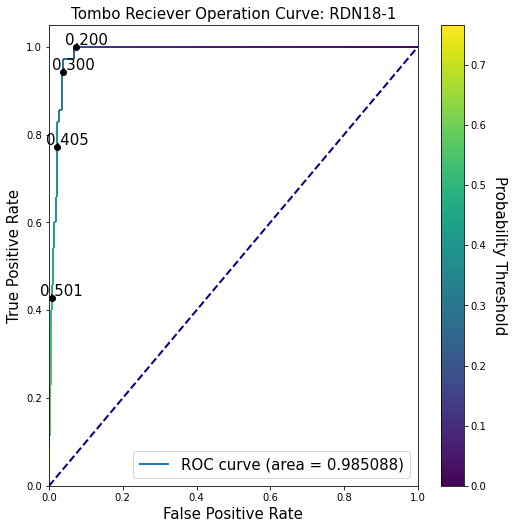

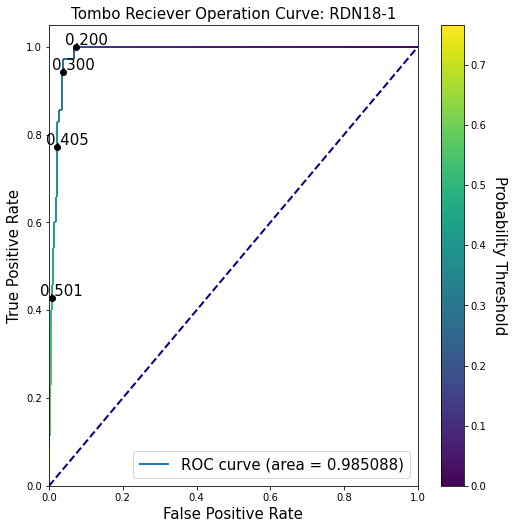

In [77]:
rrna_ref_name = "RDN18-1"
stats_file = IVT_vs_Nop58_GAL
save_fig_path=os.path.join(figures, f"tombo_{rrna_ref_name}_delta_roc.svg")
thresholds_at = [0.5000, 0.40000, 0.30000, 0.20000]
plot_tombo_roc_delta(rrna_ref_name, stats_file, save_fig_path=save_fig_path, thresholds_at=thresholds_at, delta=delta)
save_fig_path=os.path.join(figures, f"tombo_{rrna_ref_name}_delta_roc.png")
plot_tombo_roc_delta(rrna_ref_name, stats_file, save_fig_path=save_fig_path, thresholds_at=thresholds_at, delta=delta)

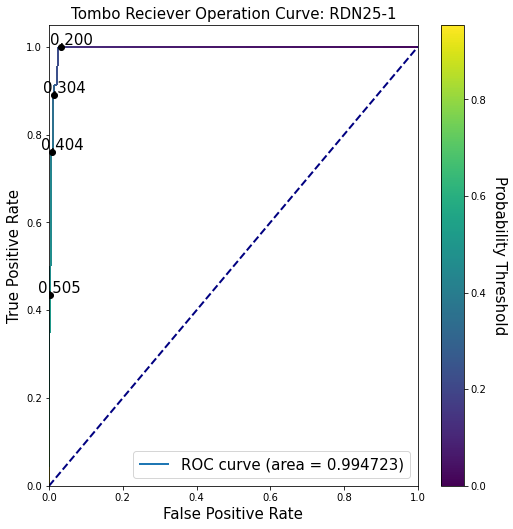

In [78]:
rrna_ref_name = "RDN25-1"
stats_file = IVT_vs_Nop58_GAL
save_fig_path=os.path.join(figures, f"tombo_{rrna_ref_name}_delta_roc.svg")
save_fig_path=None

thresholds_at = [0.5000, 0.40000, 0.30000, 0.20000]
plot_tombo_roc_delta(rrna_ref_name, stats_file, save_fig_path=save_fig_path, thresholds_at=thresholds_at, delta=3)
# save_fig_path=os.path.join(figures, f"tombo_{rrna_ref_name}_delta_roc.png")
# plot_tombo_roc_delta(rrna_ref_name, stats_file, save_fig_path=save_fig_path, thresholds_at=thresholds_at, delta=3)

In [50]:
def plot_tombo_hist_delta(stats_file, label, rrna_ref_name, mods_data=mods_data, threshold=0.2, save_fig_path=None, delta=2):
    title = f"Per-position Windowed Mean D-statistics: {rrna_ref_name}"
    raw_data, ref_positions = get_data_from_tombo(stats_file, rrna_ref_name)
    trim_start = 8
    min_ref = ref_positions[0]
    max_ref = ref_positions[-1]+1
    ref_seq = rh.get_sequence(rrna_ref_name, min_ref, max_ref)
    contig_data = mods_data[rrna_ref_name]
    label_data = pd.DataFrame(contig_data, columns=["ref_pos", "strand", "ref-base", "variants"])

    fig = plt.figure(figsize=(15, 10))
    panel1 = plt.axes([0.1, 0.1, .8, .8])
    panel1.set_xlabel("Reference")
    panel1.set_ylabel("D-statistic")
    panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)
    panel1.set_title(label=title)
    panel1.plot(ref_positions[trim_start:], raw_data[trim_start:], label=label)

    panel1.scatter(label_data["ref_pos"], [0 for x in label_data["ref_pos"]], 
                   label="Modified Positions",
                  s=50,
                  c='red')
    peaks, properties = signal.find_peaks(raw_data, height=threshold)

    above_threshold_peaks = [ref_positions[x] for x in peaks if x > trim_start]
    panel1.plot(above_threshold_peaks, [raw_data[x] for x in peaks if x > trim_start], "x", label=f"Peak > {threshold}")
    windows = pd.DataFrame([[ref_positions[x]-delta+1, ref_positions[x]+delta] for x in peaks if x > trim_start])
    panel1.hlines(y=[0 for x in windows[0]], 
                  xmin=windows[0],
                  xmax=windows[1], color = "C1", linewidth=4, label="Peak Window")
    
    all_ranges = [set(range(x-10, x+10)) for x in label_data["ref_pos"].values]
    for x in above_threshold_peaks:
        in_range = np.sum([x in mod_range for mod_range in all_ranges])
        if in_range == 0:
            print(f"Potential Mod: {x}")

    panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
    panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))

    panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

    panel1.legend()
    if save_fig_path is not None:
        plt.savefig(save_fig_path, transparent=False)
    else:
        plt.show

<IPython.core.display.Javascript object>


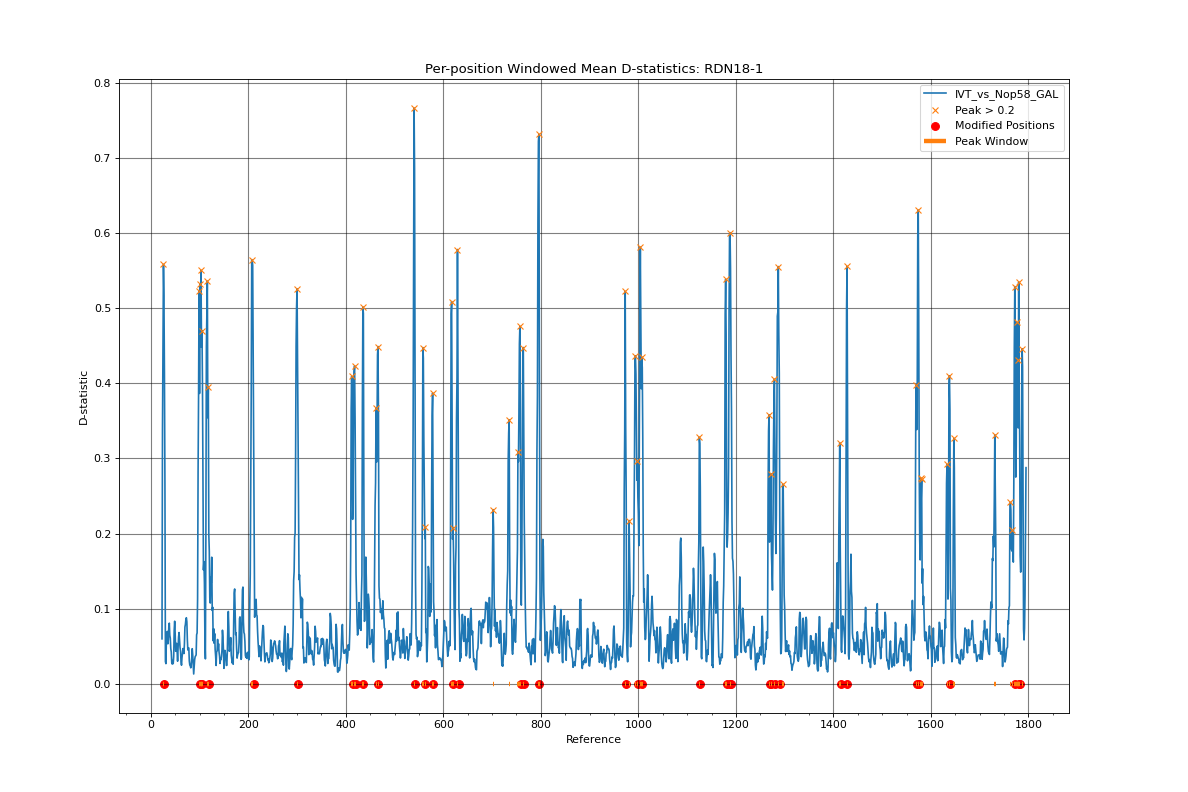

Potental Mod: 702
Potental Mod: 735
Potental Mod: 1731


In [48]:
%matplotlib notebook
rrna_ref_name = "RDN18-1"
stats_file = IVT_vs_Nop58_GAL
save_fig_path = os.path.join(figures, f"tombo_{rrna_ref_name}_delta_hist.svg")
save_fig_path = None
label = "IVT_vs_Nop58_GAL"
threshold = 0.2
delta = 2
plot_tombo_hist_delta(stats_file, label, rrna_ref_name, delta=delta, mods_data=mods_data, threshold=threshold, save_fig_path=save_fig_path)
# save_fig_path = os.path.join(figures, f"tombo_{rrna_ref_name}_delta_hist.png")
# plot_tombo_hist_delta(stats_file, rrna_ref_name, threshold=threshold, save_fig_path=save_fig_path)

<IPython.core.display.Javascript object>


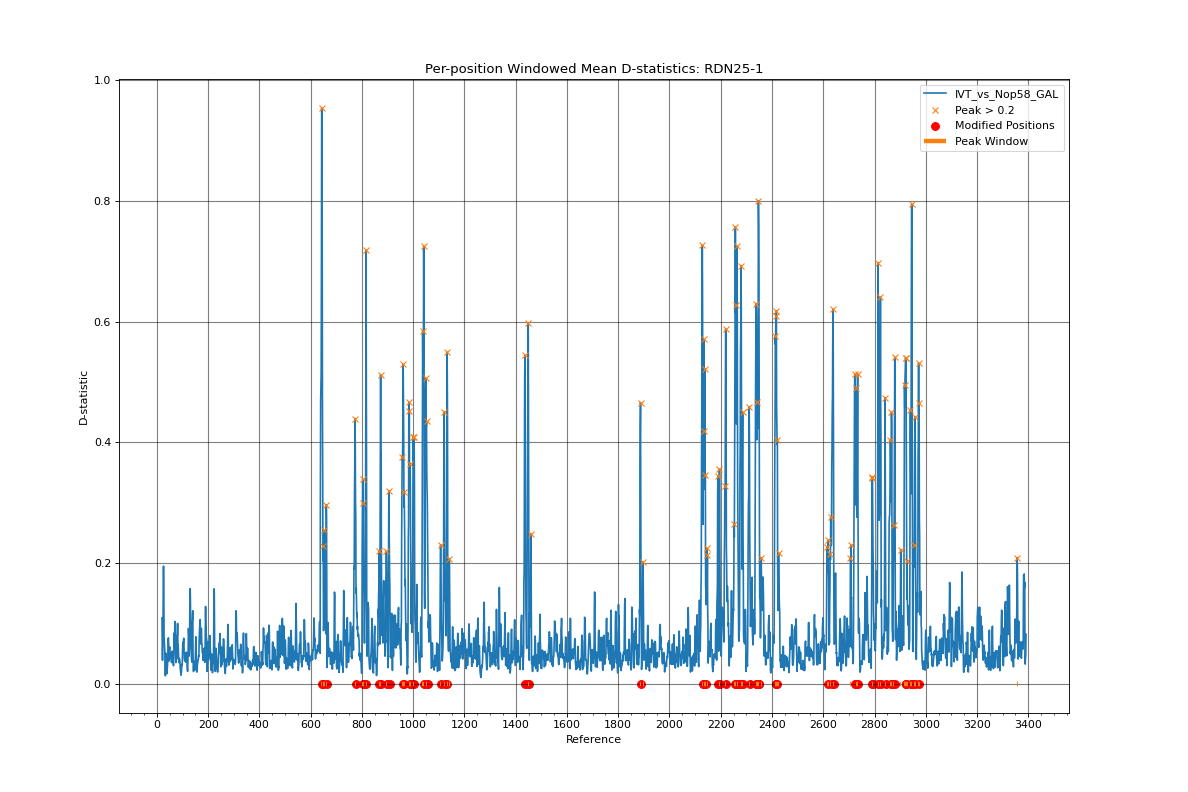

Potental Mod: 2706
Potental Mod: 2708
Potental Mod: 2902
Potental Mod: 3356


In [49]:
%matplotlib notebook
rrna_ref_name = "RDN25-1"
stats_file = IVT_vs_Nop58_GAL
save_fig_path = os.path.join(figures, f"tombo_{rrna_ref_name}_delta_hist.svg")
threshold = 0.2
save_fig_path = None
plot_tombo_hist_delta(stats_file, "IVT_vs_Nop58_GAL", rrna_ref_name, threshold=threshold, save_fig_path=save_fig_path)
# save_fig_path = os.path.join(figures, f"tombo_{rrna_ref_name}_delta_hist.png")
# plot_tombo_hist_delta(stats_file, rrna_ref_name, threshold=threshold, save_fig_path=save_fig_path)

## Nanocompore metric

In [80]:
stats_files = [nanocompore]
labels = ["IVT vs Nop58_GAL"]
rrna_ref_name = "RDN25-1"


In [81]:
def get_data(stats_file, contig_name, strand="+"):
    assert os.path.exists(stats_file)
    if stats_file.endswith("tombo.stats"):
        return get_data_from_tombo(stats_file, rrna_ref_name, strand=strand)
    else:
        return get_data_from_nanocompore(stats_file, rrna_ref_name, strand=strand)

In [82]:
def get_data_from_nanocompore(stats_file, rrna_ref_name, strand="+"):
    assert os.path.exists(stats_file)
    nanocompore_data = pd.read_csv(nanocompore, sep="\t")
    contig_data = nanocompore_data[nanocompore_data["ref_id"]==rrna_ref_name]
    return contig_data["GMM_logit_pvalue"].values, contig_data["pos"].values + 1


In [90]:
def plot_nanocompore_roc_delta(rrna_ref_name, stats_file, save_fig_path=None, thresholds_at=None, mods_data=mods_data, delta=5):
    raw_data, ref_positions = get_data(stats_file, rrna_ref_name)
    min_ref = ref_positions[0]
    max_ref = ref_positions[-1]+1
    ref_seq = rh.get_sequence(rrna_ref_name, min_ref, max_ref)
    contig_data = mods_data[rrna_ref_name]
    label_data = pd.DataFrame(contig_data, columns=["ref_pos", "strand", "ref-base", "variants"])
    all_contig_data = get_negative_lables(min_ref, ref_seq)
    all_contig_data["Dstat"] = 0
    for i, x in enumerate(raw_data):
        ref_pos = min_ref + i + 1
        if x < 0.0000001:
            x = 0
        if pd.isna(x):
            x = 1
        all_contig_data.loc[ref_pos, "Dstat"] = 1 - x
    all_contig_data["1-Dstat"] = 1 - all_contig_data["Dstat"]

    all_labelled_data = get_labelled_data(label_data, all_contig_data, delta=delta)
    # all_labelled_data.loc[all_labelled_data["Dstat"].isnull(), "Dstat"] = 1
    # all_labelled_data.loc[all_labelled_data["Dstat"].isnull(), "Dstat"] = 0

    trim_start = 8
    cm = ClassificationMetrics(all_labelled_data[["unmod", "mod"]].iloc[trim_start:], 
                               all_labelled_data[["1-Dstat", "Dstat"]].iloc[trim_start:].rename(columns={"Dstat": "mod", "1-Dstat": "unmod"}), 
                               label_ids=all_labelled_data.iloc[trim_start:].index.values)
    cm.plot_roc("mod", title=f"Nanocompore Reciever Operation Curve: {rrna_ref_name}", save_fig_path=save_fig_path, 
                thresholds_at=thresholds_at, cbar_label="p-value threshold")

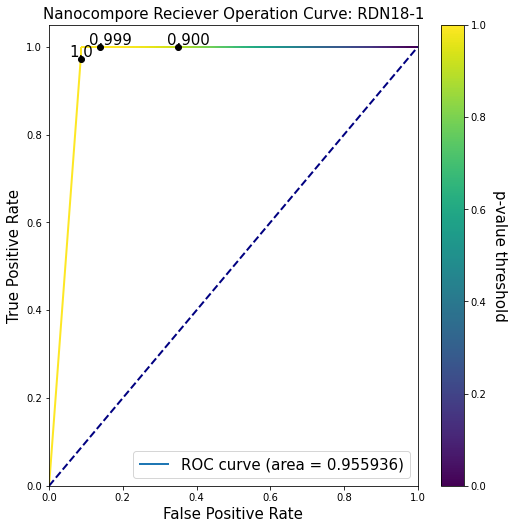

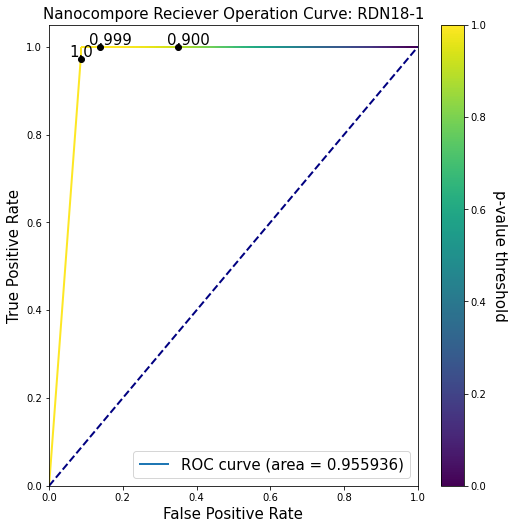

In [91]:
rrna_ref_name = "RDN18-1"
stats_file = nanocompore
thresholds_at = [1, 0.9999,  0.9]
delta=2
save_fig_path=os.path.join(figures, f"nanocompore_{rrna_ref_name}_delta_roc.svg")
plot_nanocompore_roc_delta(rrna_ref_name, stats_file, save_fig_path=save_fig_path, thresholds_at=thresholds_at, delta=delta)
save_fig_path=os.path.join(figures, f"nanocompore_{rrna_ref_name}_delta_roc.png")
plot_nanocompore_roc_delta(rrna_ref_name, stats_file, save_fig_path=save_fig_path, thresholds_at=thresholds_at, delta=delta)


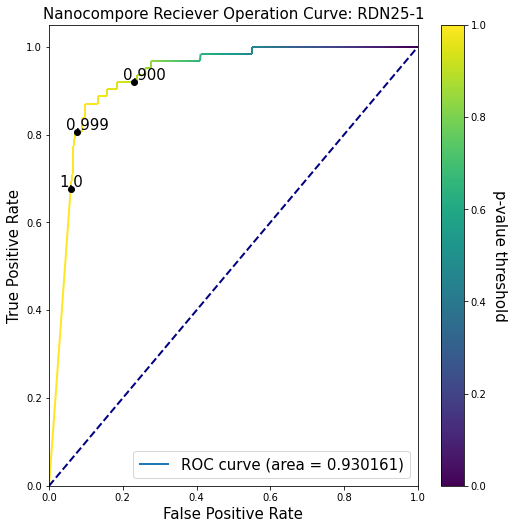

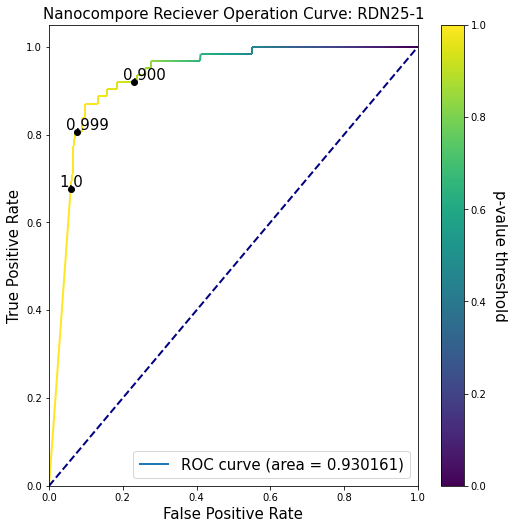

In [86]:
rrna_ref_name = "RDN25-1"
stats_file = nanocompore
thresholds_at = [1, 0.9999,  0.9]
delta=2
save_fig_path=os.path.join(figures, f"nanocompore_{rrna_ref_name}_delta_roc.svg")
plot_nanocompore_roc_delta(rrna_ref_name, stats_file, save_fig_path=save_fig_path, thresholds_at=thresholds_at, delta=delta)
save_fig_path=os.path.join(figures, f"nanocompore_{rrna_ref_name}_delta_roc.png")
plot_nanocompore_roc_delta(rrna_ref_name, stats_file, save_fig_path=save_fig_path, thresholds_at=thresholds_at, delta=delta)


## Depletions

In [92]:
CBF5_GAL_vs_CBF5_GLU = os.path.join(HOME, "tombo/CBF5_GAL_vs_GLU.level_compare_sample.tombo.stats")
CBF5_GAL_vs_NOP58_GAL = os.path.join(HOME, "tombo/CBF5_GAL_vs_NOP58_GAL.level_compare_sample.tombo.stats")
Nop58_GAL_vs_Nop58_GLU = os.path.join(HOME, "tombo/Nop58_GAL_vs_GLU.level_compare_sample.tombo.stats")
IVT_vs_CBF5_GAL_and_Nop58_GAL = os.path.join(HOME, "tombo/IVT_vs_CBF5_GAL_and_Nop58_GAL.level_compare_sample.tombo.stats")
IVT_vs_Nop58_GAL = os.path.join(HOME, "tombo/IVT_vs_Nop58_GAL.level_compare_sample.tombo.stats")


In [108]:
def generate_tombo_plots(stats_files, labels, rrna_ref_name, mods_data=mods_data, save_fig_path=None, color=True):
    title = f"Per-position Windowed Mean D-statistics: {rrna_ref_name}"

    fig = plt.figure(figsize=(20, 6))
    panel1 = plt.axes([0.1, 0.1, .8, .8])
    panel1.set_xlabel(f"{rrna_ref_name} Reference Positions")
    panel1.set_ylabel("D-statistic")
    panel1.set_title(label=title)

    panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)


    for i in range(len(stats_files)):
        assert os.path.exists(stats_files[i])
        ts = tombo_stats.TomboStats(stats_files[i])
        for contig in ts:
            if contig[0] == rrna_ref_name and contig[1] == "+":
                all_data = contig[4]
                panel1.plot([x[1] for x in all_data], [1-x[0] for x in all_data], label=labels[i])

    for i, mod in enumerate(mods_data[rrna_ref_name]):
        pos = mod[0] 
        strand = mod[1]
        find = mod[2]
        mods = mod[3]
        c = 'y'
        if color and mods == "Tl":
            c = 'r'
        if color and mods in {"Aa", "Td", "Gc", "Cb"}:
            c = 'g'
        if i == 0:
            panel1.plot(pos, 1-all_data[all_data["pos"] == pos]["stat"], color=c, linewidth=0, marker='o', ms=5, label=f"Annotated Modified Positions on {rrna_ref_name}")
        else:
            panel1.plot(pos, 1-all_data[all_data["pos"] == pos]["stat"], color=c, marker='o')


    panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
    panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))
    panel1.set_ylim(0, 1)
    panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

    panel1.legend()

    # option to save figure or just show it
    if save_fig_path is not None:
        plt.savefig(save_fig_path, transparent=False)
    else:
        plt.show()

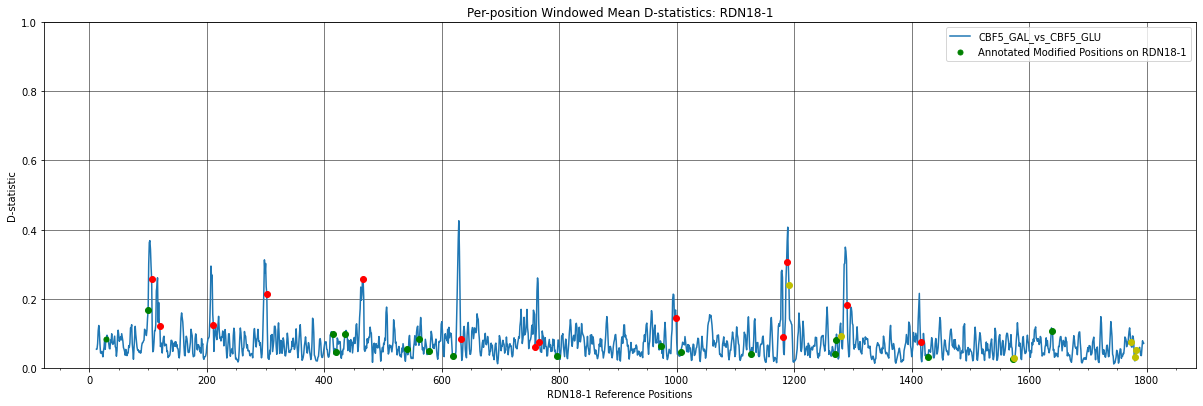

In [111]:
%matplotlib inline
# green = 2'O methyl
# red = pseduoU
# blue = other
# Nop58 = no methyl (yes green)
# cbf5 = no pseudoU (yes red)
rrna_ref_name = "RDN18-1"
stats_files = [CBF5_GAL_vs_CBF5_GLU]
labels = ["CBF5_GAL_vs_CBF5_GLU"]
save_fig_path=None
generate_tombo_plots(stats_files, labels, rrna_ref_name, save_fig_path=save_fig_path)


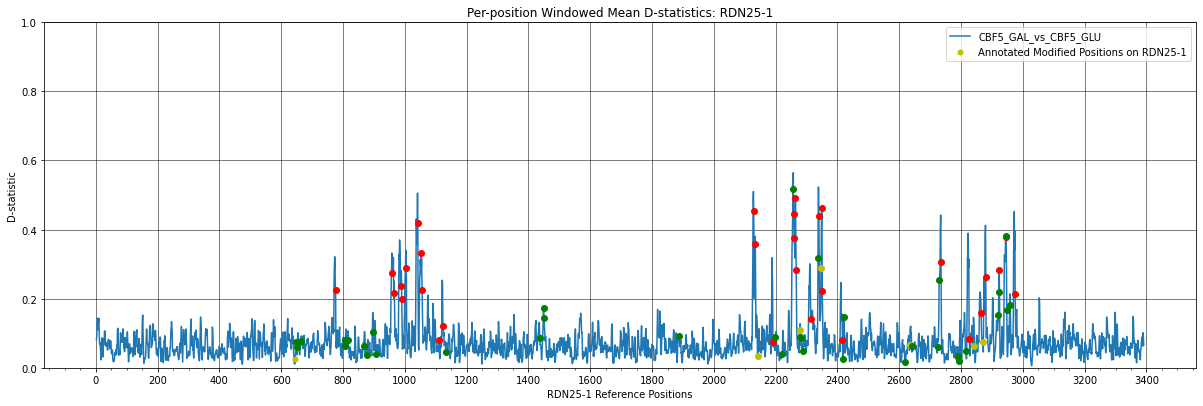

In [112]:
rrna_ref_name = "RDN25-1"
stats_files = [CBF5_GAL_vs_CBF5_GLU]
labels = ["CBF5_GAL_vs_CBF5_GLU"]
save_fig_path=None
generate_tombo_plots(stats_files, labels, rrna_ref_name, save_fig_path=save_fig_path)


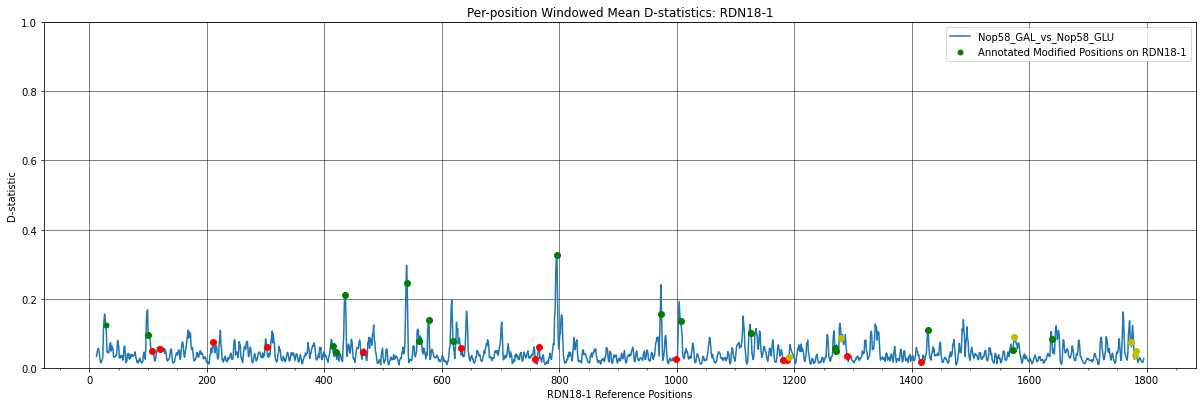

In [113]:
rrna_ref_name = "RDN18-1"
stats_files = [Nop58_GAL_vs_Nop58_GLU]
labels = ["Nop58_GAL_vs_Nop58_GLU"]
save_fig_path=None
generate_tombo_plots(stats_files, labels, rrna_ref_name, save_fig_path=save_fig_path)


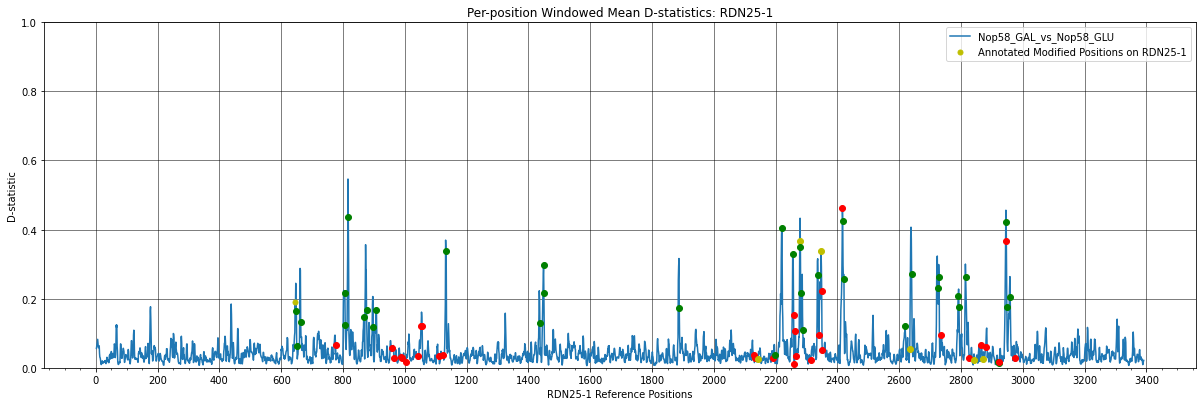

In [115]:
rrna_ref_name = "RDN25-1"
stats_files = [Nop58_GAL_vs_Nop58_GLU]
labels = ["Nop58_GAL_vs_Nop58_GLU"]
save_fig_path=None
generate_tombo_plots(stats_files, labels, rrna_ref_name, save_fig_path=save_fig_path)


# Generate Diff plots between IVT comparisons

In [81]:
def get_contig_data(tombo_stats_file, rrna_ref_name):
    assert os.path.exists(tombo_stats_file), f"{tombo_stats_file} does not exist"
    ts = tombo_stats.TomboStats(tombo_stats_file)
    for contig in ts:
        if contig[0] == rrna_ref_name and contig[1] == "+":
            return pd.DataFrame(contig[4])


In [77]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


In [105]:
def plot_sample_compare_compare(rrna_ref_name):
    IVT_vs_Nop58_GAL = os.path.join(HOME, "tombo/IVT_vs_Nop58_GAL.level_compare_sample.tombo.stats")
    IVT_vs_Nop58_GLU = os.path.join(HOME, "tombo/IVT_vs_Nop58_GLU.level_compare_sample.tombo.stats")
    IVT_vs_CBF5_GLU = os.path.join(HOME, "tombo/IVT_vs_CBF5_GLU.level_compare_sample.tombo.stats")
    color = True

    title = f"Per-position Windowed Mean D-statistics: {rrna_ref_name}"
    fig = plt.figure(figsize=(20, 6))
    panel1 = plt.axes([0.1, 0.1, .8, .8])
    panel1.set_xlabel(f"{rrna_ref_name} Reference Positions")
    panel1.set_ylabel("D-statistic")
    panel1.set_title(label=title)
    panel1.grid(color='black', linestyle='-', linewidth=1, alpha=0.5)

    ngal = get_contig_data(IVT_vs_Nop58_GAL, rrna_ref_name)
    nglu = get_contig_data(IVT_vs_Nop58_GLU, rrna_ref_name)
    cglu = get_contig_data(IVT_vs_CBF5_GLU, rrna_ref_name)
    result = pd.merge(nglu, ngal, on="pos", suffixes=["_nglu", "_ngal"])
    cglu = cglu.rename(columns={"stat": "stat_cglu", "cov": "cov_cglu", "control_cov": "control_cov_cglu"})
    all_data = pd.merge(result, cglu, on="pos")
    all_data["nglu-ngal"] = all_data["stat_nglu"] - all_data["stat_ngal"]
    all_data["cglu-ngal"] = all_data["stat_cglu"] - all_data["stat_ngal"] 
    legend_elements = []       
    ax, = panel1.plot(all_data.pos, all_data["nglu-ngal"], label="(IVT vs Nop58_GLU) - (IVT vs Nop58_GAL)")
    ax2, = panel1.plot(all_data.pos, all_data["cglu-ngal"], label="(IVT vs CBF5_GLU) - (IVT vs Nop58_GAL)")
    legend_elements.extend([ax, ax2])
    ms = 5
    for i, mod in enumerate(mods_data[rrna_ref_name]):
        pos = mod[0] 
        strand = mod[1]
        find = mod[2]
        mods = mod[3]
        c = 'y'
        if color and mods == "Tl":
            c = 'r'
        if color and mods in {"Aa", "Td", "Gc", "Cb"}:
            c = 'g'
        panel1.plot(pos, np.max([all_data[all_data["pos"] == pos]["cglu-ngal"].iloc[0], all_data[all_data["pos"] == pos]["nglu-ngal"].iloc[0]]), color=c, marker='o', markersize=ms)

    ax = Line2D([0], [0], marker='o', color='w', markerfacecolor='y', label="Other Modification", markersize=ms)
    legend_elements.append(ax)
    ax = Line2D([0], [0], marker='o', color='w', markerfacecolor='r', label="Pseudouridine", markersize=ms)
    legend_elements.append(ax)
    ax = Line2D([0], [0], marker='o', color='w', markerfacecolor='g', label="2'O methyl", markersize=ms)
    legend_elements.append(ax)


    # for i, mod in enumerate(mods_data[rrna_ref_name]):
    #     pos = mod[0] 
    #     strand = mod[1]
    #     find = mod[2]
    #     mods = mod[3]
    #     if i == 0:
    #         panel1.plot(pos, 0, color='r', linewidth=0, marker='o', ms=5, label=f"Annotated Modified Positions on {rrna_ref_name}")
    #     else:
    #         panel1.plot(pos, 0, color='r', marker='o')





    panel1.xaxis.set_major_locator(ticker.MultipleLocator(200))
    panel1.xaxis.set_minor_locator(ticker.MultipleLocator(50))
    panel1.set_ylim(-.5, .5)
    panel1.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

    panel1.legend(handles=legend_elements)

    # option to save figure or just show it
    if save_fig_path is not None:
        plt.savefig(save_fig_path, transparent=False)
    else:
        plt.show

<IPython.core.display.Javascript object>


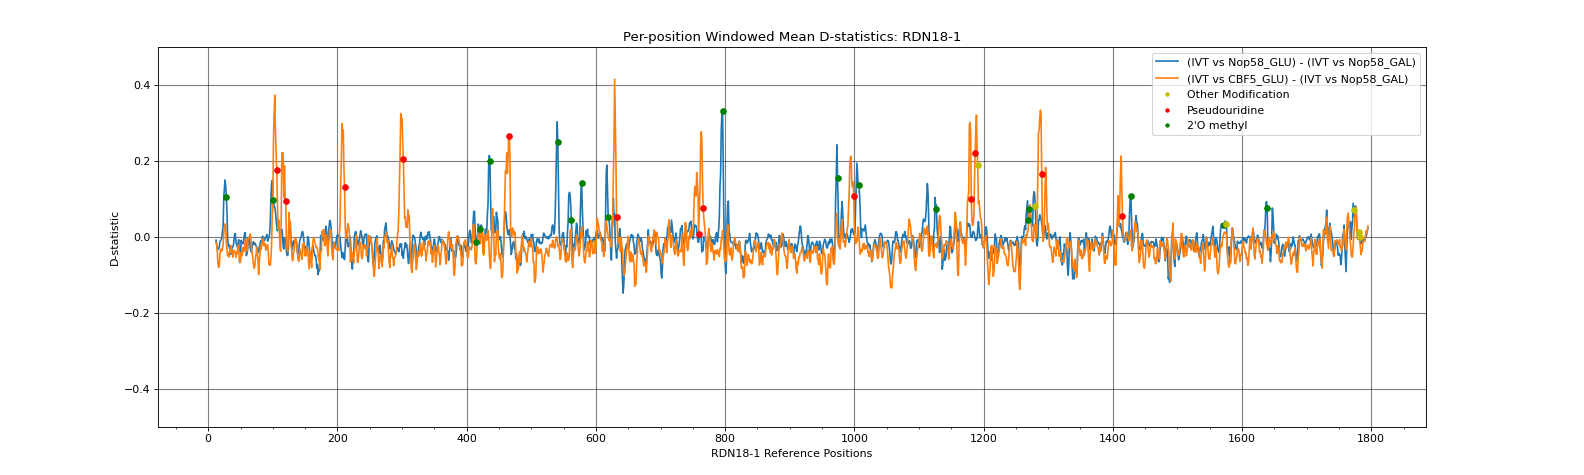

In [106]:
rrna_ref_name = "RDN18-1"
plot_sample_compare_compare(rrna_ref_name)

<IPython.core.display.Javascript object>


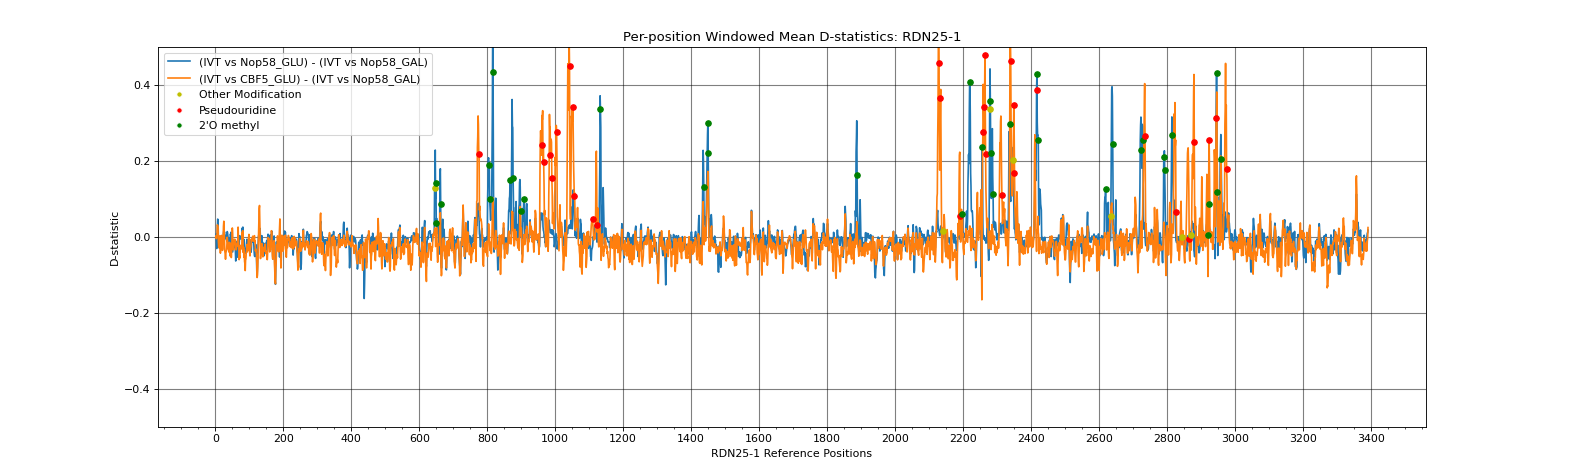

In [107]:
rrna_ref_name = "RDN25-1"
plot_sample_compare_compare(rrna_ref_name)